### Unconditional density estmation
Here we will use a [masked_autoregressive_flow](../api/flows.rst#flowjax.flows.masked_autoregressive_flow)
with a [RationalQuadraticSpline](../api/bijections.rst#flowjax.bijections.RationalQuadraticSpline) transformer
to approximate the "two-moons" distribution. For a list of available flow architectures, please see [flowjax.flows](../api/flows.rst).

Importing the required libraries.

In [8]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from flowjax.bijections import RationalQuadraticSpline
from flowjax.distributions import Normal
from flowjax.flows import masked_autoregressive_flow
from flowjax.tasks import two_moons
from flowjax.train import fit_to_data

Generating the the toy dataset.

In [9]:
n_samples = 10000
rng = jr.key(0)
x = two_moons(rng, n_samples)
x = (x - x.mean(axis=0)) / x.std(axis=0)  # Standardize

We can now create the flow. We use a normal base distribution, and define the spline transformer to have 8 knots on the interval [-4,4]. Note that we could use other bijections for the transformer (e.g. [Affine](../api/bijections.rst#flowjax.bijections.Affine)).

In [10]:
key, subkey = jr.split(jr.key(0))
flow = masked_autoregressive_flow(
    subkey,
    base_dist=Normal(jnp.zeros(x.shape[1])),
    transformer=RationalQuadraticSpline(knots=8, interval=4),
)

Training the flow.

In [12]:
key, subkey = jr.split(key)
flow, losses = fit_to_data(subkey, flow, x, learning_rate=1e-3)

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:15<01:07,  1.20it/s, train=1.5550615, val=1.5777681 (Max patience reached)]


We can use the flow to evaluate the density of arbitrary points

In [13]:
five_points = jnp.ones((5, 2))
flow.log_prob(five_points)

Array([-8.443225, -8.443225, -8.443225, -8.443225, -8.443225], dtype=float32)

and we can sample the flow

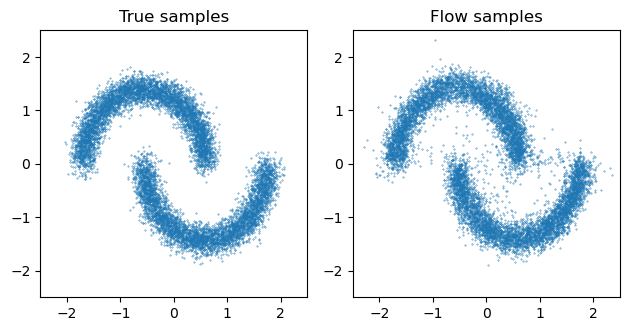

In [14]:
key, subkey = jr.split(key)
x_samples = flow.sample(subkey, (n_samples,))

fig, axs = plt.subplots(ncols=2)

axs[0].scatter(x[:, 0], x[:, 1], s=0.1)
axs[0].set_title("True samples")

axs[1].scatter(x_samples[:, 0], x_samples[:, 1], s=0.1)
axs[1].set_title("Flow samples")

lims = (-2.5, 2.5)
for ax in axs:
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect("equal")

plt.tight_layout()
plt.show()